# Notebook 1 for System Biology of Aging 
This notebook is part of the first session of the 2024 Systems Biology of Aging Workshop. But don't worry about setup, all of the files and R packages should be installed in the the Sagemaker environment.

This Notebook will use the "custom-R" kernel. Double check that this is correct by looking in the top right corner.


Does this need to be copyied and saved? 
Do we want to link to anything? 
Any disclaimers?


> Creating a final Notebook 1
> TODO:
> * Time cells and generate any output that needs to be loaded
> * Update all links for Sagemaker directory

> Outline
> * Data exploration and cleaning
> ** Dispersion of frailty measures
> ** Create baseline proteins, metabolites and clinical
> * Dimensionality reduction
> ** Scale and impute for PCA
> * Single-Omics DE
> ** DE of Proteins and Metabolites quintiles
> ** Volcano plots
> ** Enrichment
> * Single-Omic WGNCA
> ** Correlate with frailty
> ** Enrichment of select modules
> * Multi-Omic WGCNA
> ** Correlate with frailty
> ** Multiomic ssgsea

## Setup
The next couple blocks of code will load the R packages into our notebook and set some options for prettier visualizaions.

In [2]:
# Load packages, one per line for clarity
suppressMessages(library("tidyverse", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("ggplot2", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("WGCNA", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("org.Hs.eg.db", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("GO.db", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("clusterProfiler", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library( "enrichplot", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("limma", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("DT", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("ggpubr", quietly = TRUE, warn.conflicts=FALSE))



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:b

In [3]:
# Other options
source("Scripts/Workshop_scripts.R") # Functions for plotting
options(stringsAsFactors=FALSE)#Required for WGCNA
enableWGCNAThreads(nThreads=2) # 
options(repr.plot.width=7, repr.plot.height=7)#Default=7x7
options(warn=-1)

Allowing parallel execution with up to 2 working processes.


# Let's Get Started! -Frailty measures

Now that our environment is ready, let's start digging into our data. In your Sagemaker environment, you should see a folders with tsv files for each of the omics and outcomes. We'll go over all of these during the anlaysis, but let's start by looking at our outcome- the frailty indices.

In [4]:
#fr_measures = read_delim("../data/frailty/combination_fi_040124.csv")
fr_measures = read_delim("/shared-libs/useful-files/frailty_measures_kanelab/FI_workshop_040124/combination_fi_040124.csv", show_col_types = FALSE, delim=",")
dim(fr_measures)
head(fr_measures)
colnames(fr_measures)

New names:
• `` -> `...1`


[1] 3090   83

...1,public_client_id,self_fi,self_fi_sum,num_na_self,days_in_program,sex,age,race,Dise1,⋯,BP1,BP2,BP3,BP4,BP5,num_na_lab,lab_fi,lab_fi_sum,num_na_both,merge_fi
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,01001548,0.18857143,6.6,0,4,M,49,white,0,⋯,1,1,NA,1,0,1,0.36363636,12,1,0.27352941
2,01002192,0.11428571,4.0,0,0,M,26,white,0,⋯,1,1,NA,1,0,1,0.27272727,9,1,0.19117647
3,01003555,0.15757576,5.2,2,0,M,47,white,0,⋯,1,1,NA,1,0,1,0.33333333,11,3,0.24545454
4,01003662,0.16285714,5.7,0,1,M,26,white,0,⋯,0,1,NA,0,0,1,0.27272727,9,1,0.21617647
5,01006695,0.16000000,5.6,0,0,M,61,white,0,⋯,0,0,NA,0,0,1,0.03030303,1,1,0.09705882
6,01007032,0.07428571,2.6,0,0,M,48,ashkenazi jewish,0,⋯,0,1,NA,0,0,1,0.18181818,6,1,0.12647059


[1] "...1"             "public_client_id" "self_fi"          "self_fi_sum"     
 [5] "num_na_self"      "days_in_program"  "sex"              "age"             
 [9] "race"             "Dise1"            "Dise2"            "Dise3"           
[13] "Dise4"            "Dise5"            "Dise6"            "Dise7"           
[17] "Dise8"            "Dise9"            "Dise10"           "Dise11"          
[21] "Dise12"           "Dise13"           "Dise14"           "Dise15"          
[25] "SAT_1"            "SAT_2"            "SAT_3"            "SAT_4"           
[29] "SAT_5"            "SAT_6"            "ACT_1"            "ACT_2"           
[33] "ACT_3"            "ACT_4"            "ACT_5"            "ACT_6"           
[37] "ACT_7"            "ACT_8"            "ACT_9"            "Med_1"           
[41] "Med_2"            "Med_3"            "Diges1"           "Diges2"          
[45] "CHEM1"            "CHEM2"            "CHEM3"            "CHEM4"           
[49] "CHEM5"            "CHEM6"            "CHEM7"            "CHEM8"           
[53] "CHEM9"            "CHEM10"           "CHEM11"           "CHEM12"          
[57] "CHEM13"           "CHEM14"           "CHEM15"           "CHEM16"          
[61] "CHEM17"           "CHEM18"           "CHEM19"           "CHEM20"          
[65] "CHEM21"           "CHEM22"           "CHEM23"           "CHEM24"          
[69] "CHEM25"           "CHEM26"           "CHEM27"           "CHEM28"          
[73] "CHEM29"           "BP1"              "BP2"              "BP3"             
[77] "BP4"              "BP5"              "num_na_lab"       "lab_fi"          
[81] "lab_fi_sum"       "num_na_both"      "merge_fi"

In [5]:
fr_measures_key = read_delim("FI_Features.txt", show_col_types = FALSE, delim="\t")

In [6]:
fr_measures_key

Code,Feature
<chr>,<chr>
Dise1,autoimmune
Dise2,bladder_kidney
Dise3,cancer
Dise4,cardiometabolic
Dise5,cardiovascular
Dise6,eye_ear_nose_throat
Dise7,fatigue
Dise8,gut_gi
Dise9,lungs


To see the number of timepoints of the frailty index, we look at the frequency tables of the participants.

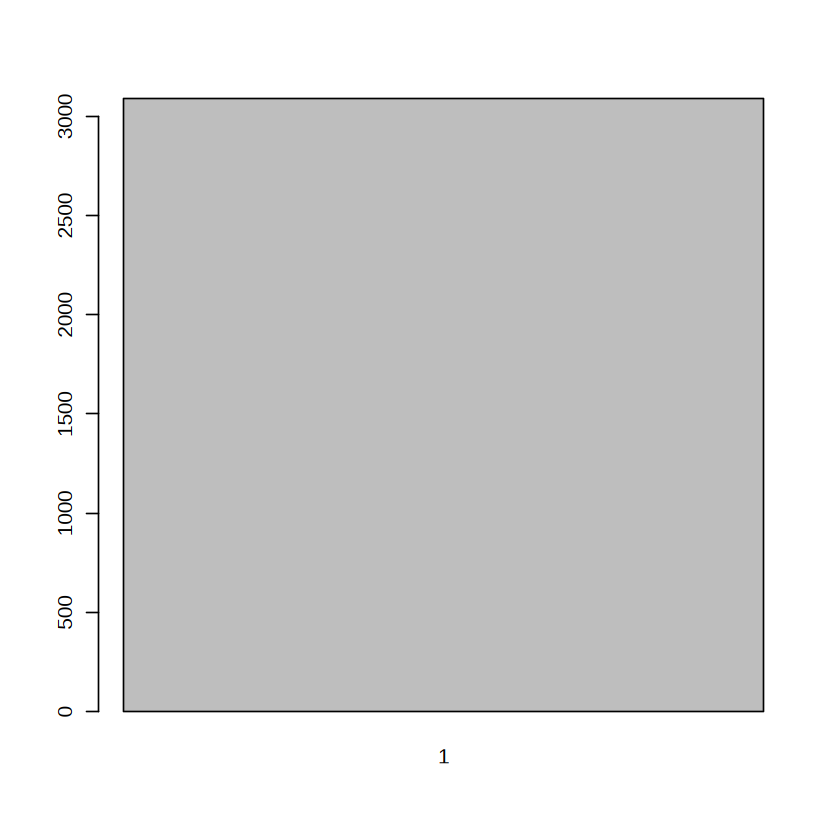

In [7]:
barplot(table(table(fr_measures$public_client_id)))

So its a boring plot- but we can see that frailty was only calculated at 1 timepoint for each participant. Looking a bit closer, we see that this was the closest timepoint to the blood draw for the omics samples.

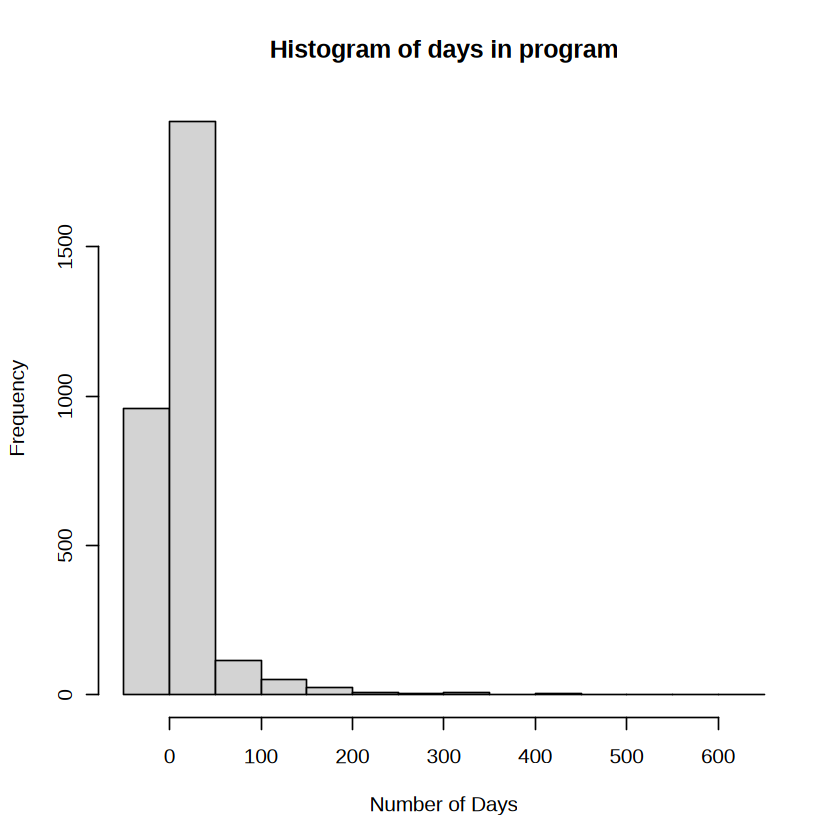

In [8]:
hist(fr_measures$days_in_program, main = "Histogram of days in program",xlab = 'Number of Days')

Next, let's look at the distribution for each of the frailty measures: lab, self assessment and the merged.

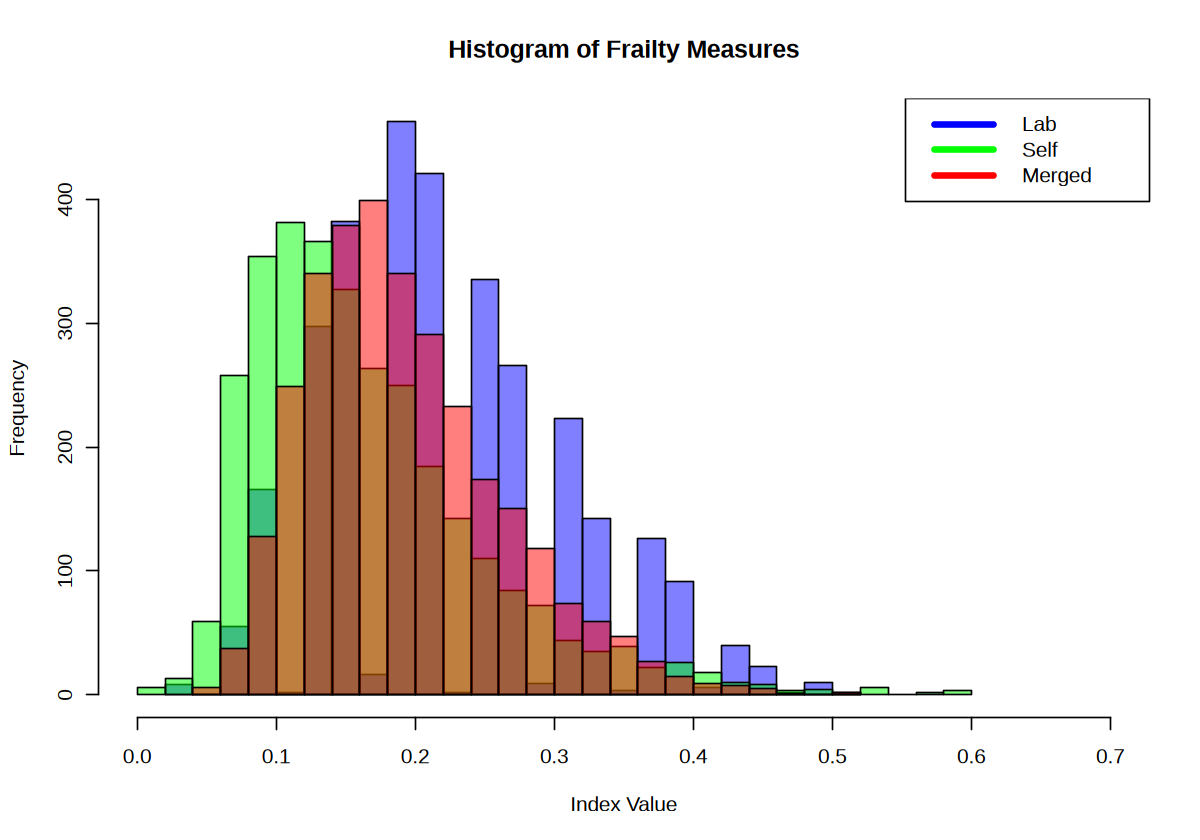

In [9]:
options(repr.plot.width=10, repr.plot.height=7)#Default=7x7
hist(fr_measures$lab_fi,  xlim=c(0,.7), col=rgb(0,0,1,2/4), breaks=25, main = "Histogram of Frailty Measures",xlab = 'Index Value') # Blue
hist(fr_measures$self_fi, add=T, xlim=c(0,.7), col=rgb(0,1,0,2/4), breaks=25) # Green
hist(fr_measures$merge_fi, add=T, xlim=c(0,.7), col=rgb(1,0,0,2/4), breaks=25) # Red

legend("topright",  c("Lab", "Self", "Merged"), lwd=4, col=c("blue","green", "red"))

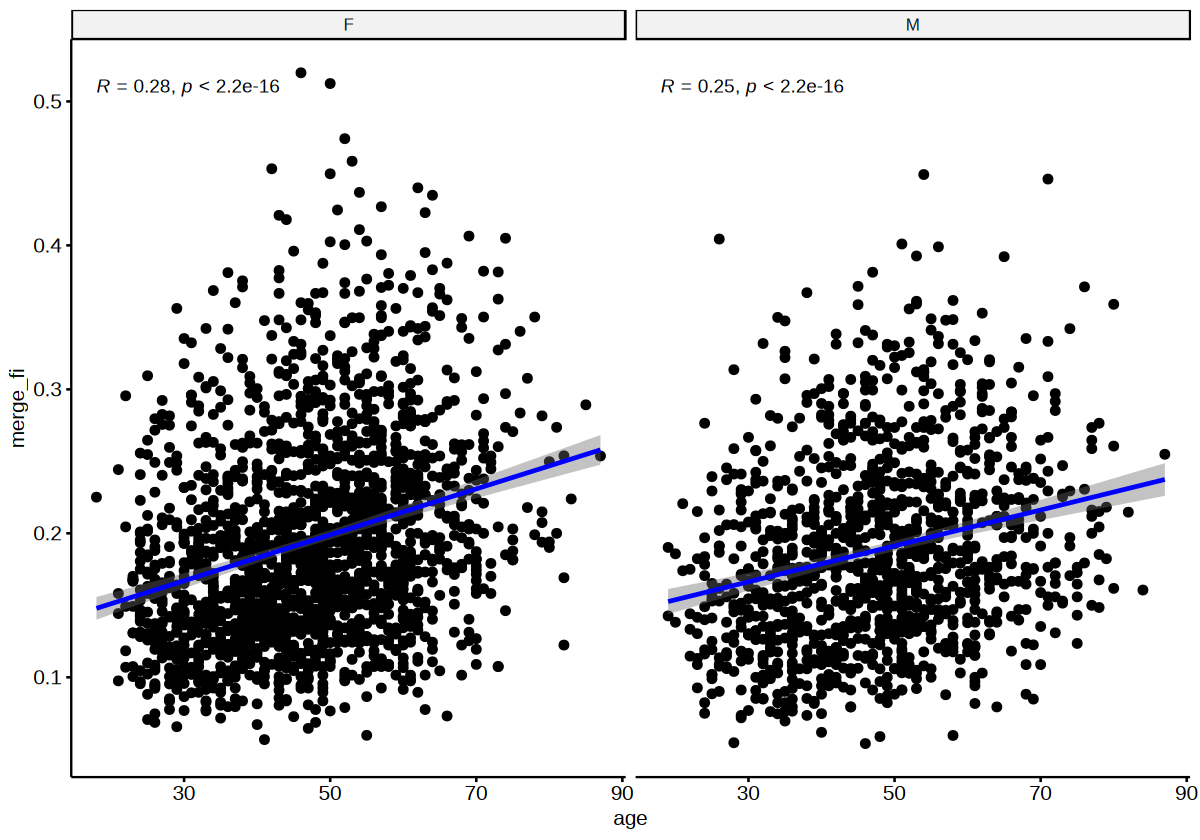

In [10]:
p1 <- ggscatter(fr_measures, x = "age", y = "merge_fi",
          add = "reg.line",                                 # Add regression line
          conf.int = TRUE,                                  # Add confidence interval
          add.params = list(color = "blue",
                            fill = "dimgrey")
          )+
  stat_cor(method = "pearson")
facet(p1, facet.by = "sex")

# Data Cleaning

In [156]:
# Load the data
# Proteins
#meta_protein = read_delim("../data/arivale_snapshot_ISB_2019-05-10_0053/proteomics_metadata.tsv", skip=13, delim='\t', show_col_types = FALSE)
#proteins = read_delim("../data/arivale_snapshot_ISB_2019-05-10_0053/proteomics_corrected.tsv", skip=13, delim='\t', show_col_types = FALSE)
meta_protein <- read_delim("/shared-data/snapshots/arivale_snapshot_ISB_2020-03-16_2156/proteomics_metadata.tsv", skip=13, delim='\t', show_col_types = FALSE)
proteins <- read_delim("/shared-data/snapshots/arivale_snapshot_ISB_2020-03-16_2156/proteomics_corrected.tsv", skip=13, delim='\t', show_col_types = FALSE)

# Metabolites
#meta_metabolites = read_delim("../data/arivale_snapshot_ISB_2019-05-10_0053/metabolomics_metadata.tsv", skip=13, delim='\t', show_col_types = FALSE)
#metabolites = read_delim("../data/arivale_snapshot_ISB_2019-05-10_0053/metabolomics_corrected.tsv", skip=13, delim='\t', show_col_types = FALSE)
meta_metabolites <- read_delim("/shared-data/snapshots/arivale_snapshot_ISB_2020-03-16_2156/metabolomics_metadata.tsv", skip=13, delim='\t', show_col_types = FALSE)
metabolites <- read_delim("/shared-data/snapshots/arivale_snapshot_ISB_2020-03-16_2156/metabolomics_corrected.tsv", skip=13, delim='\t', show_col_types = FALSE)

# Clinical chemistries
#metabolites = read_delim("../data/arivale_snapshot_ISB_2019-05-10_0053/chemistries.tsv", skip=13, delim='\t', show_col_types = FALSE)
chemistry <- read_delim("/shared-data/snapshots/arivale_snapshot_ISB_2020-03-16_2156/chemistries.tsv", skip=13, delim='\t', show_col_types = FALSE)


## Metabolomics
Lets look at the data!

In [157]:
#Load the data
head(metabolites)
head(meta_metabolites)
tail(meta_metabolites)

public_client_id,sample_id,days_in_program,days_since_first_call,days_since_first_draw,month,weekday,season,35,50,⋯,999953114,999953157,999953172,999953266,999953267,999954831,999954832,999954834,999954839,999954840
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01000261,A477AV558-002,65,-9,0,Jan,Tue,winter,0.9722221,2.5688976,⋯,1.0451515,0.5921748,0.4373467,0.6150178,0.9234049,1.1065246,1.1293211,1.1365539,0.3767863,NA
01001621,A391BM948-002,265,223,254,Apr,Wed,spring,1.8193021,0.7040975,⋯,NA,0.7376484,1.1092093,0.3913661,0.8446087,NA,NA,NA,NA,NA
01001621,A776BI445-003,11,-31,0,Jul,Mon,summer,2.5403780,0.5682363,⋯,2.1987038,1.0366094,2.8619600,0.9800132,1.2459661,NA,NA,NA,NA,NA
01002183,A595AV320-002,13,-1,0,Jan,Wed,winter,0.5288041,2.2607295,⋯,0.7721458,3.1092914,1.6894408,0.9235939,0.8960287,0.9159573,0.8598838,0.8627062,0.3644502,0.9324695
01002412,A294AU415-002,13,-6,0,Nov,Thu,fall,0.8631524,0.5353168,⋯,0.7252146,1.7022579,1.1553911,1.1510215,NA,0.9134076,0.8862591,NA,0.2142912,0.6393869
01002471,A945BJ353-009,194,168,153,Oct,Tue,fall,2.2329326,2.7808248,⋯,1.2253432,1.0657910,NA,NA,0.6870790,NA,NA,NA,NA,0.8164034


CHEMICAL_ID,SUB_PATHWAY,SUPER_PATHWAY,BIOCHEMICAL_NAME,CAS,KEGG,HMDB,PUBCHEM,MEAN_WITHIN_BATCH_CV,MEDIAN_WITHIN_BATCH_CV,ACROSS_BATCH_CV,NUM_CONTROLS_DETECTED,PERCENT_CONTROLS_DETECTED,TOTAL_CONTROLS,NUM_SAMPLES_DETECTED,PERCENT_SAMPLES_DETECTED,TOTAL_SAMPLES
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,Glutamate Metabolism,Amino Acid,S-1-pyrroline-5-carboxylate,2906-39-0,C04322,HMDB01301,1196,0.16220230,0.13934147,0.1926359,326,0.8670213,376,3320,0.9011944,3684
50,Polyamine Metabolism,Amino Acid,spermidine,124-20-9,C00315,HMDB01257,1102,0.24137319,0.18207422,0.3032631,327,0.8696809,376,3260,0.8849077,3684
55,Nicotinate and Nicotinamide Metabolism,Cofactors and Vitamins,1-methylnicotinamide,1005-24-9,C02918,HMDB00699,457,0.05088571,0.05013201,0.1159510,353,0.9388298,376,3478,0.9440825,3684
62,"Fatty Acid, Dihydroxy",Lipid,"12,13-DiHOME",263399-35-5,C14829,HMDB04705,10236635,0.21650512,0.18795428,0.2638650,339,0.9015957,376,3145,0.8536916,3684
71,Tryptophan Metabolism,Amino Acid,5-hydroxyindoleacetate,54-16-0,C05635,HMDB00763,1826,0.18691303,0.18084506,0.2482783,127,0.3377660,376,1512,0.4104235,3684
93,TCA Cycle,Energy,alpha-ketoglutarate,305-72-6;328-50-7;22202-68-2,C00026,HMDB00208,51,0.11480845,0.08352945,0.2005657,349,0.9281915,376,3504,0.9511401,3684


CHEMICAL_ID,SUB_PATHWAY,SUPER_PATHWAY,BIOCHEMICAL_NAME,CAS,KEGG,HMDB,PUBCHEM,MEAN_WITHIN_BATCH_CV,MEDIAN_WITHIN_BATCH_CV,ACROSS_BATCH_CV,NUM_CONTROLS_DETECTED,PERCENT_CONTROLS_DETECTED,TOTAL_CONTROLS,NUM_SAMPLES_DETECTED,PERCENT_SAMPLES_DETECTED,TOTAL_SAMPLES
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
999954832,NA,NA,X - 24804,NA,NA,NA,NA,0.03848047,0.03535528,0.0794717,30,0.07978723,376,981,0.2662866,3684
999954834,NA,NA,X - 24806,NA,NA,NA,NA,0.08258662,0.03767936,0.1231948,31,0.08244681,376,974,0.2643865,3684
999954839,NA,NA,X - 24811,NA,NA,NA,NA,0.14930633,0.14222407,0.2756181,201,0.53457447,376,1534,0.4163952,3684
999954840,NA,NA,X - 24812,NA,NA,NA,NA,0.15537343,0.13476987,0.1767202,323,0.85904255,376,2732,0.7415852,3684
100002397,NA,NA,alpha-ketoglutaramate*,18465-19-5,NA,NA,48,0.10969206,0.09293088,0.1626516,56,0.14893617,376,406,0.1102063,3684
100020578,NA,NA,4-allylcatechol sulfate,NA,NA,NA,NA,0.05278329,0.05036630,0.1963823,359,0.95478723,376,3337,0.9058089,3684


### Drop metabolites without annotations

In [158]:
new_names <- sapply(colnames(metabolites), function(x) {
  if (x %in% meta_metabolites$CHEMICAL_ID) {
      newrow <- meta_metabolites[meta_metabolites$CHEMICAL_ID %in% x,]
    paste0(x, "(", newrow[,'BIOCHEMICAL_NAME'], ")")
  } else {
    x
  }
})

colnames(metabolites) <- new_names

In [159]:
print("Metabolites")
print(str_c("- columns: ", ncol(metabolites)))
metabolites <- metabolites[,!grepl("X -", colnames(metabolites))]
print("Metabolites after filtering")
print(str_c("- columns: ", ncol(metabolites)))

[1] "Metabolites"
[1] "- columns: 1304"
[1] "Metabolites after filtering"
[1] "- columns: 1058"


### Get baseline metabolites

Considering these participants underwent wellness coaching, we will only look at the baseline analysis for looking at associations with frailty indices. 

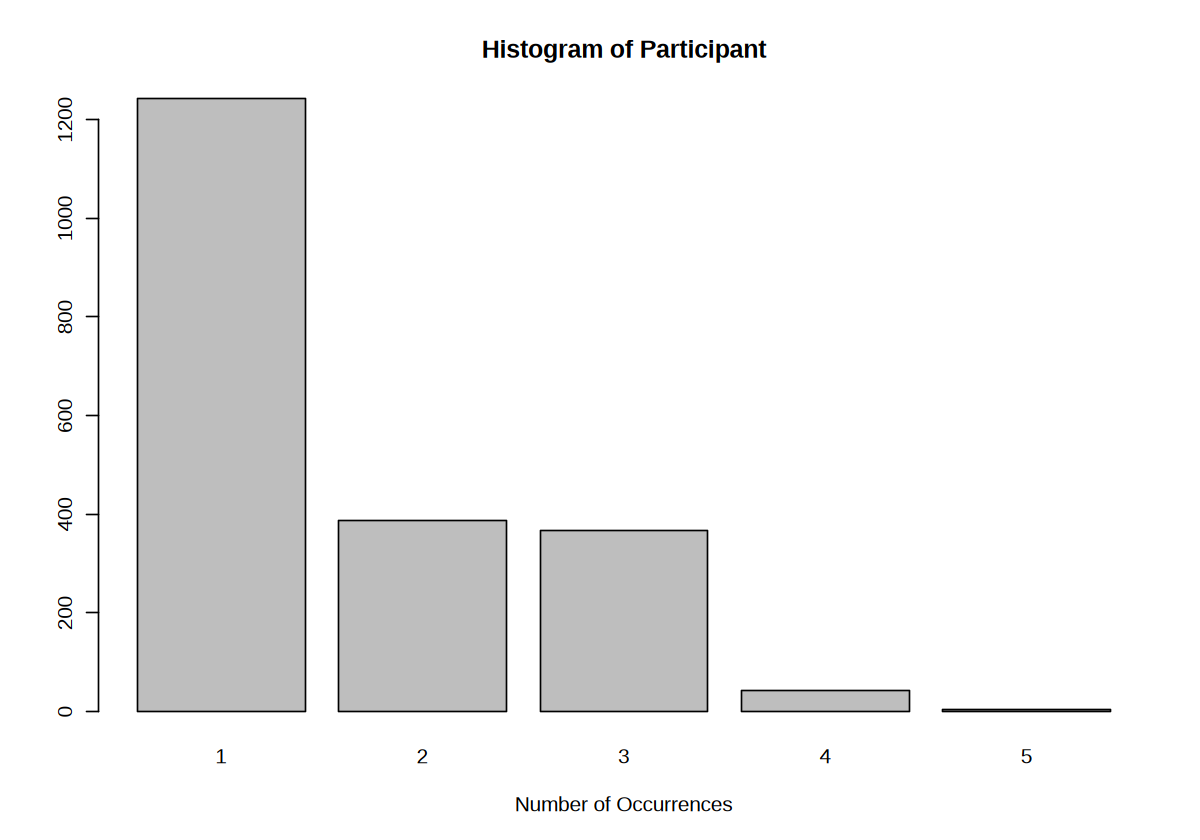

In [160]:
barplot(table(table(metabolites$public_client_id)), main = "Histogram of Participant",xlab = 'Number of Occurrences')

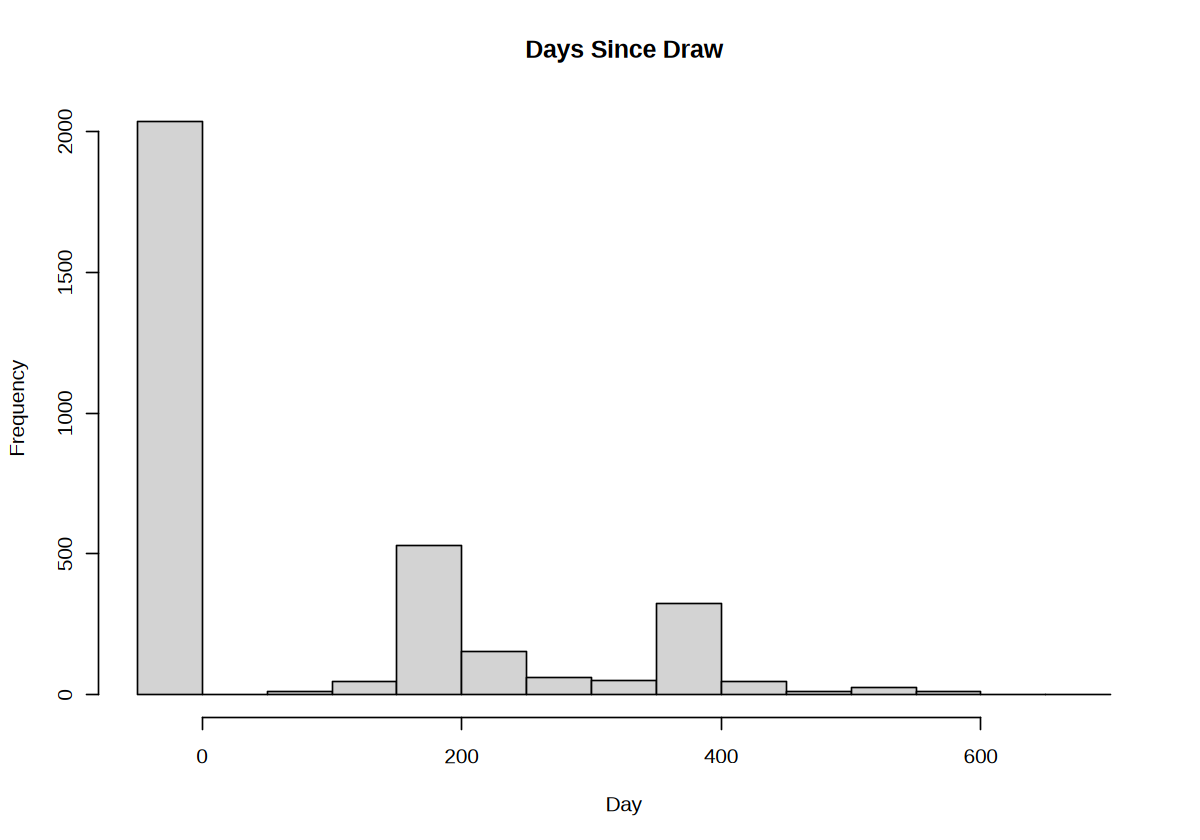

In [161]:
hist(metabolites$days_since_first_draw, main = "Days Since Draw",xlab = 'Day')

In [162]:
print("Participants metabolite records")
print(str_c("- columns: ", nrow(metabolites)))
metabolites <-metabolites %>% 
    group_by(public_client_id) %>%
    arrange(days_since_first_draw) %>%
    filter(row_number()==1) %>%
    filter(days_since_first_draw < 75)

print("Participants metabolite records after filtering")
print(str_c("- columns: ", nrow(metabolites)))

[1] "Participants metabolite records"
[1] "- columns: 3305"
[1] "Participants metabolite records after filtering"
[1] "- columns: 2033"


### Evaluate Missingess

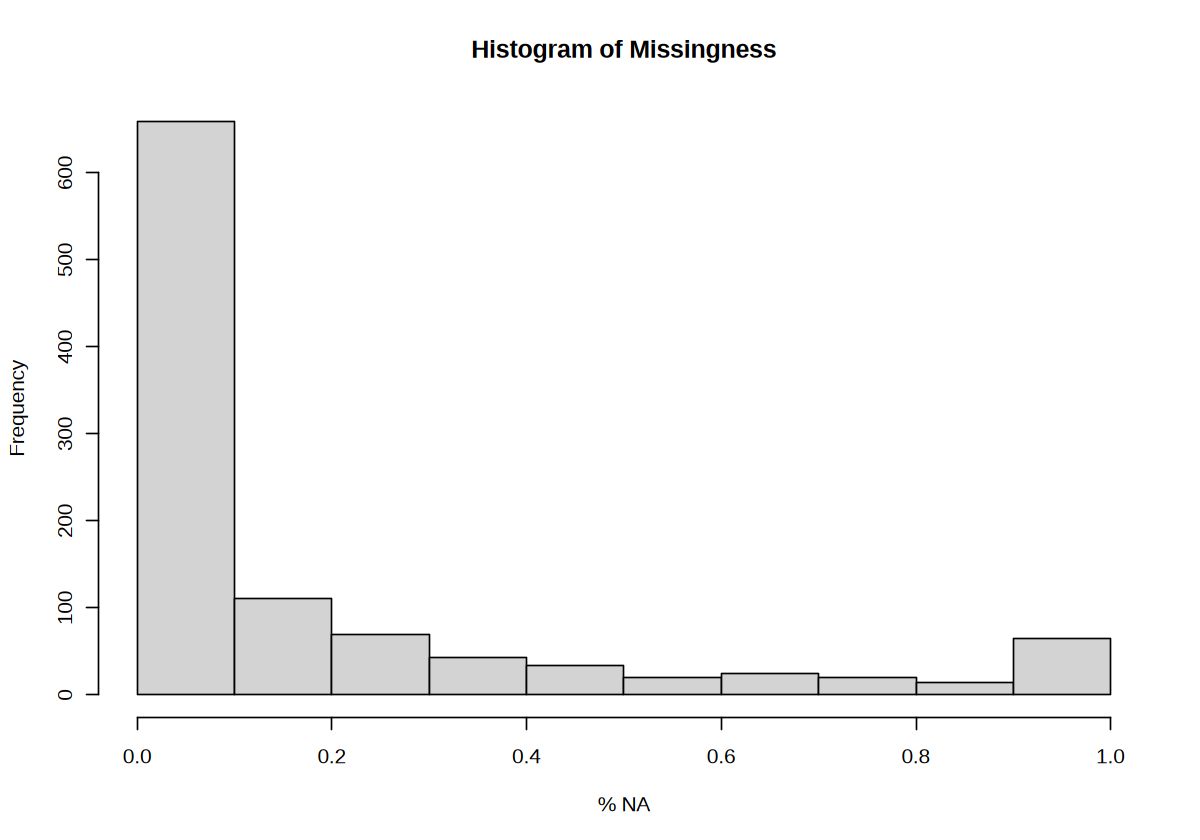

In [163]:
mets_missing <- colSums(is.na(metabolites))/nrow(metabolites)
hist(mets_missing, main = "Histogram of Missingness",xlab = '% NA')

In [164]:
mets_missing[order(mets_missing, decreasing = TRUE)[1:10]]

100001538(lidocaine) 
                                    1.0000000 
                  100002719(cotinine N-oxide) 
                                    1.0000000 
                        100003442(paroxetine) 
                                    1.0000000 
100002394(1-hydroxy-2-naphthalenecarboxylate) 
                                    0.9995081 
                          100006381(tramadol) 
                                    0.9995081 
                 100009253(mycophenolic acid) 
                                    0.9995081 
        100004177(hydroxypioglitazone (M-IV)) 
                                    0.9990162 
                      100001317(pioglitazone) 
                                    0.9985243 
                        100008943(pregabalin) 
                                    0.9985243 
                         100004015(diltiazem) 
                                    0.9980325

### Impute and Scale

When dealing with metabolites, its important to consider the method of imputation! For example, imputing with the mean or median may result in incorrect values for xenobiotics. More sophisticated imputation methods, such as random forest can be costly. 

In [165]:
metabolites_filter <- metabolites[,c(9:ncol(metabolites))] # Drop non metabolite values
metabolites_filter <- metabolites_filter[, colMeans(is.na(metabolites_filter)) <= .5]
metabolites_filter_impute <- as_tibble(impute::impute.knn(as.matrix(metabolites_filter))$data)
head(metabolites_filter_impute)

Cluster size 2028 broken into 55 1973 
Done cluster 55 
Cluster size 1973 broken into 1899 74 
Cluster size 1899 broken into 156 1743 
Done cluster 156 
Cluster size 1743 broken into 1688 55 
Cluster size 1688 broken into 1373 315 
Done cluster 1373 
Done cluster 315 
Done cluster 1688 
Done cluster 55 
Done cluster 1743 
Done cluster 1899 
Done cluster 74 
Done cluster 1973 


35(S-1-pyrroline-5-carboxylate),50(spermidine),55(1-methylnicotinamide),"62(12,13-DiHOME)",71(5-hydroxyindoleacetate),93(alpha-ketoglutarate),98(kynurenate),111(3-hydroxyisobutyrate),112(3-hydroxy-3-methylglutarate),117(homovanillate (HVA)),⋯,"100022004(bilirubin degradation product, C16H18N2O5 (2)**)","100022005(bilirubin degradation product, C17H18N2O4 (1)**)","100022006(bilirubin degradation product, C17H18N2O4 (2)**)","100022007(bilirubin degradation product, C17H18N2O4 (3)**)","100022008(bilirubin degradation product, C17H20N2O5 (1)**)","100022009(bilirubin degradation product, C17H20N2O5 (2)**)",100022013(tetrahydrocortisol glucuronide),"100022041(N,N-dimethyl-pro-pro)",100022120(oxindolylalanine),100022127(tetrahydrocortisone glucuronide (5))
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8120445,0.9717836,1.4747071,0.3945273,1.2629148,2.7345234,1.3664110,1.2565792,1.2118343,1.467920,⋯,1.7741423,1.2738873,1.3448638,1.3579382,2.0115281,2.0524588,1.1295823,0.9427496,0.6110228,0.8964159
0.9722221,2.5688976,1.1557715,0.8244348,1.6660605,0.9475890,0.7729551,0.7168306,1.1931153,1.265563,⋯,1.0878299,1.2611141,1.0077579,0.9236489,1.2349962,1.2123621,1.7550796,1.2159123,0.8757674,1.5780188
2.5403780,0.5682363,1.3280497,0.7049045,1.0030309,1.3669079,0.9675743,1.9571495,0.9285327,1.164143,⋯,0.2333235,0.2679000,0.3057815,0.2835381,0.1699744,0.1867472,0.8384159,0.9834853,1.1259881,0.4805284
0.5288041,2.2607295,0.4250734,2.2997951,1.9403741,0.8505769,1.7378101,1.4784967,2.3359559,2.452279,⋯,1.9288947,1.7604692,1.4839163,1.4906687,2.1887822,2.2421221,1.0052202,1.4960280,0.4003367,0.9035022
0.8631524,0.5353168,1.0084296,1.3006848,1.2235681,0.8771391,0.7723711,1.0520635,1.1289915,1.649449,⋯,1.1126312,1.0528709,1.0452474,1.0194556,0.7990516,0.8499786,1.1582496,0.9424226,0.5686666,0.7830649
2.0649952,1.1113569,1.3083215,0.7738525,0.7559647,0.7600328,1.1209268,0.8643912,0.3036506,1.173906,⋯,0.7752223,0.5537469,0.6009769,0.7277116,0.9066635,0.9152842,1.3953714,0.9953826,1.1683813,1.2185600


### PCA

In [166]:
PCA_mets_all <- prcomp(metabolites_filter_impute, center=TRUE, scale=TRUE)
PCA_mets <- cbind(metabolites[,c(1:8)], PCA_mets_all$x[,c(1:4)])
PCA_mets <- merge(PCA_mets, fr_measures, by="public_client_id")

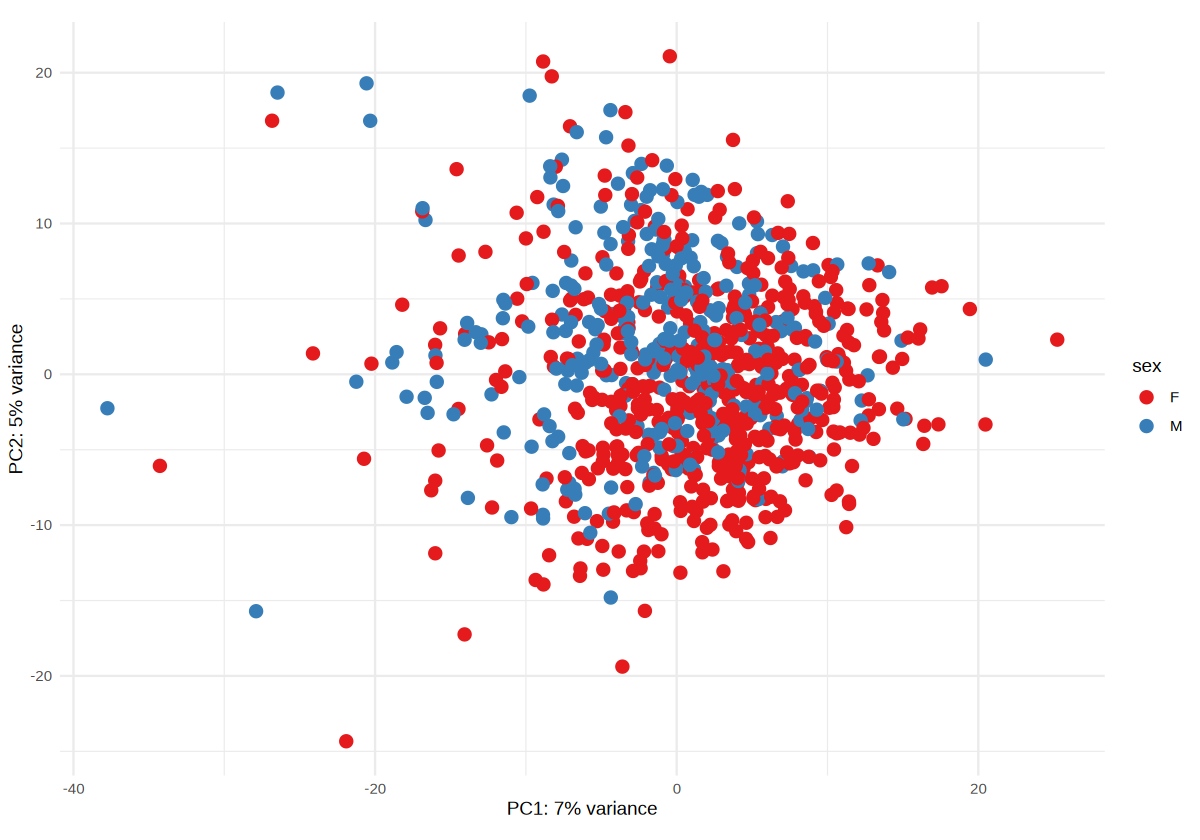

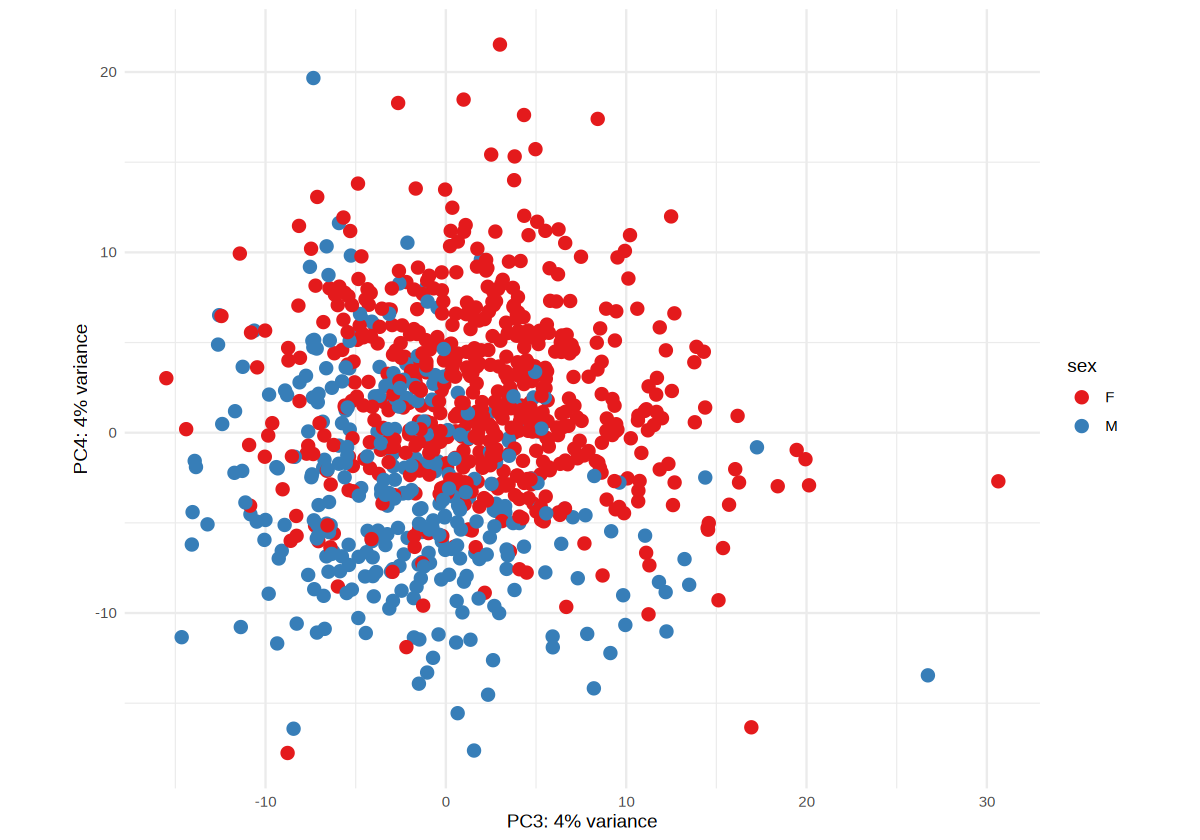

In [167]:
percentVar <- PCA_mets_all$sdev^2 / sum(PCA_mets_all$sdev^2 )

ggplot(PCA_mets, aes(x=PC1, y=PC2, color=sex)) +
    geom_point(size=3) + scale_color_brewer(palette="Set1") +
    xlab(paste0("PC1: ",round(percentVar[1] * 100),"% variance")) +
    ylab(paste0("PC2: ",round(percentVar[2] * 100),"% variance")) +
     theme_minimal() +
    coord_fixed()
ggplot(PCA_mets, aes(x=PC3, y=PC4, color=sex)) +
    geom_point(size=3) + scale_color_brewer(palette="Set1") +
    xlab(paste0("PC3: ",round(percentVar[3] * 100),"% variance")) +
    ylab(paste0("PC4: ",round(percentVar[4] * 100),"% variance")) +
     theme_minimal() +
    coord_fixed()

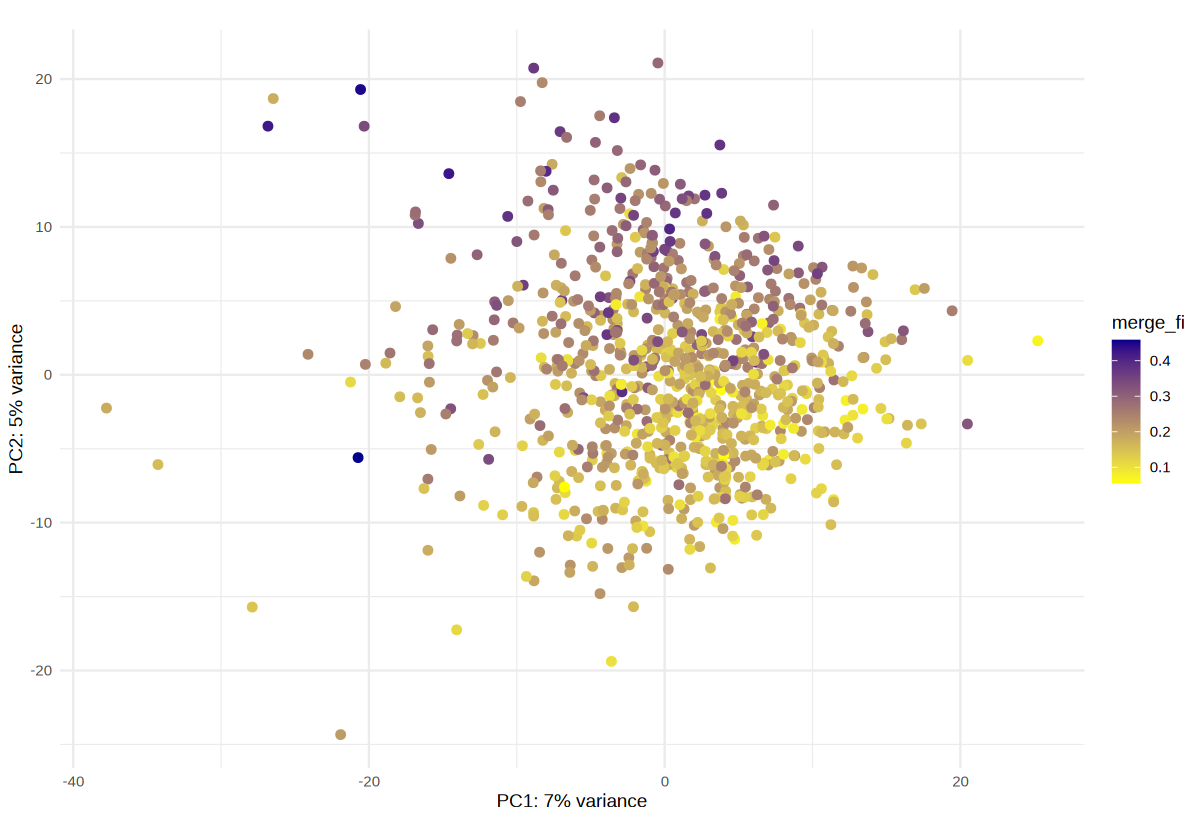

In [168]:
ggplot(PCA_mets, aes(x=PC1, y=PC2, color=merge_fi)) +
    geom_point(size=2) + scale_color_gradient(low = "yellow", high = "darkblue") +
    xlab(paste0("PC1: ",round(percentVar[1] * 100),"% variance")) +
    ylab(paste0("PC2: ",round(percentVar[2] * 100),"% variance")) +
    theme_minimal() +
    coord_fixed()

 We'll leave it there for now, but will come back to PCA in session three.

## Proteins

Proteins follow the same analysis pattern as metabolites. We'll skip going over in detail. 

In [169]:
new_names <- sapply(colnames(proteins), function(x) {
  if (x %in% meta_protein$name) {
      newrow <- meta_protein[meta_protein$name %in% x,]
    paste0(x, "(", newrow[,'gene_name'], ")")
  } else {
    x
  }
})

colnames(proteins) <- new_names

print("Participants protein records")
print(str_c("- columns: ", nrow(proteins)))
proteins <-proteins %>% 
    group_by(public_client_id) %>%
    arrange(days_since_first_draw) %>%
    filter(row_number()==1) %>%
    filter(days_since_first_draw < 75)

print("Participants protein records")
print(str_c("- columns: ", nrow(proteins)))

[1] "Participants protein records"
[1] "- columns: 6112"
[1] "Participants protein records"
[1] "- columns: 2839"


### Exercise 1

What, if anything, needs to be considered when imputing and filtering proteins?
Try 3 imputation methods, Zero, Mean and KNN. Does this change the PCA?

## Clinical Labs

In [171]:
print("Participants chemisty records")
print(str_c("- columns: ", nrow(chemistry)))
chemistry <-chemistry %>% 
    group_by(public_client_id) %>%
    arrange(days_since_first_draw) %>%
    filter(row_number()==1) %>%
    filter(days_since_first_draw < 75)

print("Participants chemistry records")
print(str_c("- columns: ", nrow(chemistry)))

[1] "Participants chemisty records"
[1] "- columns: 11167"
[1] "Participants chemistry records"
[1] "- columns: 4878"


In [172]:
colnames(chemistry)

[1] "public_client_id"               "vendor"                        
  [3] "vendor_observation_id"          "observation_id"                
  [5] "reflexive"                      "fasting"                       
  [7] "days_in_program"                "days_since_first_call"         
  [9] "days_since_first_draw"          "month"                         
 [11] "weekday"                        "season"                        
 [13] "A/G RATIO"                      "ADIPONECTIN, SERUM"            
 [15] "ALAT (SGPT)"                    "ALBUMIN"                       
 [17] "ALKALINE PHOSPHATASE"           "ANTIOXID CAP, TOTAL"           
 [19] "ARACHIDONIC ACID"               "ARSENIC, BLOOD"                
 [21] "ASAT (SGOT)"                    "BASOPHILS"                     
 [23] "BASOPHILS ABSOLUTE"             "BILIRUBIN, DIRECT"             
 [25] "BILIRUBIN, INDIRECT"            "BILIRUBIN, TOTAL"              
 [27] "BUN/CREAT RATIO"                "CALCIUM"                       
 [29] "CARBON DIOXIDE (CO2)"           "CHLORIDE"                      
 [31] "CHOLESTEROL, TOTAL"             "COPPER, RBC"                   
 [33] "CREATININE ENZ, SER"            "CRP HIGH SENSITIVITY"          
 [35] "DHA"                            "DPA"                           
 [37] "EOSINOPHILS"                    "EOSINOPHILS ABSOLUTE"          
 [39] "EPA"                            "EPA/AA"                        
 [41] "FERRITIN"                       "FOLIC ACID, SERUM"             
 [43] "GFR, MDRD"                      "GFR, MDRD, AFRICAN AM"         
 [45] "GGT"                            "GLOBULIN"                      
 [47] "GLUCOSE"                        "GLUTATHIONE, TOTAL"            
 [49] "GLYCOHEMOGLOBIN A1C"            "HDL CHOL DIRECT"               
 [51] "HDL LARGE"                      "HDL PARTICLE NUMBER"           
 [53] "HDL PARTICLE PERCENTILE"        "HDL SIZE PERCENTILE"           
 [55] "HEMATOCRIT"                     "HEMOGLOBIN"                    
 [57] "HOMA-IR"                        "HOMOCYSTEINE, SERUM"           
 [59] "IDL PARTICLE NUMBER"            "IL-6"                          
 [61] "IL-8"                           "IMMATURE GRANULOCYTES"         
 [63] "IMMATURE GRANULOCYTES ABSOLUTE" "INSULIN"                       
 [65] "LACTIC DEHYDROGENASE"           "LARGE HDL PARTICLE PERCENTILE" 
 [67] "LARGE LDL PARTICLE NUMBER"      "LARGE MED HDL PARTICLE NUMBER" 
 [69] "LARGE MED VLDL PARTICLE NUMBER" "LARGE VLDL PARTICLE PERCENTILE"
 [71] "LDL MEDIUM"                     "LDL PARTICLE NUMBER"           
 [73] "LDL PEAK SIZE"                  "LDL SIZE PERCENTILE"           
 [75] "LDL SMALL"                      "LDL-CHOL CALCULATION"          
 [77] "LDL_SIZE"                       "LEAD, BLOOD"                   
 [79] "LINOLEIC_ACID"                  "LPIR SCORE PERCENTILE"         
 [81] "LPIR_SCORE"                     "LP_PLA2"                       
 [83] "LYMPHOCYTES"                    "LYMPHOCYTES ABSOLUTE"          
 [85] "MAGNESIUM, SERUM"               "MANGANESE, SERUM"              
 [87] "MCH"                            "MCHC"                          
 [89] "MCV"                            "MEDIUM HDL PARTICLE NUMBER"    
 [91] "MEDIUM VLDL PARTICLE NUMBER"    "MERCURY, BLOOD"                
 [93] "METHYLMALONIC ACID"             "MONOCYTES"                     
 [95] "MONOCYTES ABSOLUTE"             "MPV"                           
 [97] "NEUTROPHIL, SEGS"               "NEUTROPHILS ABSOLUTE"          
 [99] "OMEGA-3 INDEX"                  "OMEGA-6/OMEGA-3 RATIO"         
[101] "OMEGA_3_TOTAL"                  "OMEGA_6_TOTAL"                 
[103] "OXLDL"                          "PAI-1 ANTIGEN, QNT"            
[105] "PFFA"                           "PHOSPHORUS INORGANIC"          
[107] "PLATELET COUNT"                 "PLATELET COUNT THOUSAND"       
[109] "POTASSIUM"                      "PROT AND PFFA CALC"            
[111] "PROTEIN"                        "PR

In [188]:
### Save these for later to re-run analysis below without having to run the code above. 
dir.create("./Session1_files/", showWarnings = FALSE)
write_delim(metabolites[,c(1,9:ncol(metabolites))], "./Session1_files/metabolites_baseline.tsv", delim="\t")
write_delim(proteins[,c(1,22:ncol(proteins))], "./Session1_files/proteins_baseline.tsv", delim="\t")
write_delim(chemistry[,c(1,13:ncol(chemistry))], "./Session1_files/chemistries_baseline.tsv", delim="\t")

# Differential Quantification 

public_client_id,35(S-1-pyrroline-5-carboxylate),50(spermidine),55(1-methylnicotinamide),"62(12,13-DiHOME)",71(5-hydroxyindoleacetate),93(alpha-ketoglutarate),98(kynurenate),111(3-hydroxyisobutyrate),112(3-hydroxy-3-methylglutarate),⋯,"100022004(bilirubin degradation product, C16H18N2O5 (2)**)","100022005(bilirubin degradation product, C17H18N2O4 (1)**)","100022006(bilirubin degradation product, C17H18N2O4 (2)**)","100022007(bilirubin degradation product, C17H18N2O4 (3)**)","100022008(bilirubin degradation product, C17H20N2O5 (1)**)","100022009(bilirubin degradation product, C17H20N2O5 (2)**)",100022013(tetrahydrocortisol glucuronide),"100022041(N,N-dimethyl-pro-pro)",100022120(oxindolylalanine),100022127(tetrahydrocortisone glucuronide (5))
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MUMA,0.8120445,0.9717836,1.4747071,0.3945273,1.2629148,2.7345234,1.3664110,1.2565792,1.2118343,⋯,1.7741423,1.2738873,1.3448638,1.3579382,2.0115281,2.0524588,1.1295823,0.9427496,0.6110228,0.8964159
01000261,0.9722221,2.5688976,1.1557715,0.8244348,1.6660605,0.9475890,0.7729551,0.7168306,1.1931153,⋯,1.0878299,1.2611141,1.0077579,0.9236489,1.2349962,1.2123621,1.7550796,1.2159123,0.8757674,1.5780188
01001621,2.5403780,0.5682363,1.3280497,NA,1.0030309,1.3669079,0.9675743,1.9571495,0.9285327,⋯,0.2333235,0.2679000,0.3057815,0.2835381,0.1699744,0.1867472,0.8384159,0.9834853,1.1259881,0.4805284
01002183,0.5288041,2.2607295,0.4250734,2.2997951,1.9403741,0.8505769,1.7378101,NA,2.3359559,⋯,1.9288947,1.7604692,1.4839163,1.4906687,2.1887822,2.2421221,1.0052202,1.4960280,0.4003367,0.9035022
01002412,0.8631524,0.5353168,1.0084296,1.3006848,1.2235681,0.8771391,0.7723711,1.0520635,1.1289915,⋯,1.1126312,1.0528709,1.0452474,1.0194556,0.7990516,0.8499786,1.1582496,0.9424226,0.5686666,0.7830649
01002471,2.0649952,NA,1.3083215,0.7738525,NA,0.7600328,1.1209268,0.8643912,0.3036506,⋯,0.7752223,0.5537469,0.6009769,0.7277116,0.9066635,0.9152842,1.3953714,0.9953826,1.1683813,1.2185600
01003555,0.7135705,0.8971787,0.9766760,0.8203673,0.9644767,1.9644552,1.4155879,0.8431044,1.3896810,⋯,0.4977120,0.6781028,0.6946121,0.6800713,0.6872652,0.5187768,NA,1.1630514,0.9110428,0.8704054
01003758,0.7791507,0.7352115,1.8811605,2.2542881,NA,0.9536744,0.6669129,0.9895124,1.0400507,⋯,1.0331232,1.0036825,0.9156847,1.0012502,1.1612450,NA,0.3844235,0.9212725,0.9319797,0.7067516
01004551,0.9242902,0.7835138,0.8196155,0.8651158,1.3996344,0.9966101,0.6594499,0.4864253,0.7913338,⋯,0.3759594,0.4364087,0.5390259,0.4986982,0.1618778,0.1749503,0.3487506,1.0559567,0.9041330,0.5364525
